In [1]:
import os

import torch
import numpy as np

from model import model_MAF
from model.modules import data_preprocessing
#from model.modules import dataset_supercell_timestep as dataset
from model.modules import dataset_supercell_timestep_full_rad as dataset
from model.modules import loader
from model.modules import utils
from model.modules import visualizations
from radiation_complex_amplitude import instananeousRadiation as instRad

import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as tick
from matplotlib import cm

plt.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['lines.linewidth']=6
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

#get_radiation_data = data_preprocessing.get_radiation_spectra_2_projections
get_radiation_data = data_preprocessing.get_radiation_spectra

In [2]:
def plot_hist(pc, pc_pred, axs, comp_x, label_x):
    axs.hist(pc[:,comp_x], density=True, bins=30, label='Groundtruth', alpha = 0.4)  # density=False would make counts
    axs.hist(pc_pred[:,comp_x], density=True, bins=30, label='Reconstruction', alpha = 0.4)  # density=False would make counts
    axs.set_ylabel('Probability')
    axs.set_xlabel(label_x)
    axs.grid(True)
    axs.legend(fontsize=18)

def plot_2D_GTandRec(pc, pc_pred, comp_x, comp_y, axs, label_x, label_y):
    axs.scatter(pc[:,comp_x], pc[:,comp_y], s=30, alpha=0.75, label='Groundtruth')
    if pc_pred is not None:
        axs.scatter(pc_pred[:,comp_x], pc_pred[:,comp_y], s=30, alpha=0.4, label='Prediction')
    axs.tick_params(axis='y', which='major', rotation=45)
    axs.grid(True)
    axs.set_xlabel(label_x)
    axs.set_ylabel(label_y)
    axs.legend(fontsize=18)
    
def plot_2D(pc, comp_x, comp_y, axs, label_x, label_y):
    axs.scatter(pc[:,comp_x], pc[:,comp_y], s=15, alpha=0.2)
    axs.tick_params(axis='y', which='major', rotation=45)
    axs.grid(True)
    axs.set_xlabel(label_x)
    axs.set_ylabel(label_y)
    
def reject_outliers(data, m=4):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [3]:
timesteps = ['10000', '10100', '10200', '10300', '10400', '10500', '10600', '10700', '10800', '10900', '11000']
timestep = timesteps[7]
print(timestep)

10700


In [10]:
unique_supercells = []
all_timesteps = []

unique_supercells = ['/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/'+nextfile for nextfile in os.listdir('/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI') if timesteps[7] in nextfile]
print(unique_supercells)
supercell = '_'.join(unique_supercells[0].split('/')[-1].split('.')[0].split('_')[1:])
all_timesteps = ['/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/'+nextfile for nextfile in os.listdir('/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI') if supercell in nextfile]
print(supercell)
all_timesteps.sort()
for timestep in all_timesteps:
    print(timestep)

['/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/10700_43_1150_51.npy', '/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/10700_44_1151_51.npy', '/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/10700_43_1151_51.npy', '/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/10700_44_1150_50.npy', '/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/10700_43_1150_50.npy', '/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/10700_43_1151_50.npy', '/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/10700_44_1151_50.npy', '/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/10700_44_1150_51.npy']
43_1150_51
/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/10700_43_1150_51.npy
/bigdata/hplsim/aipp/Anna/lwfa_2cells_unitSI/10900_43_1150_51.npy


In [29]:
def get_radiation(path_to_phase_space):
    # define e.g.
    # frequency
    omega = np.linspace(1e2, 5e2, 128) # [rad/s]
    # observation direction
    theta = np.linspace(0, np.pi/2, 16) # [rad]
    n = np.array([np.sin(theta), np.cos(theta), np.zeros_like(theta)]).T
    # time step duration
    delta_t = 1.2e-15 # [s]
    # simulation box size
    sim_box_size = np.array([100, 100, 100]) # [m, m, m]

    # create object
    comp_rad = instRad.instantaneousRadiation(omega, n, delta_t, sim_box_size)

    # get your particle data
    # ...
    
    time = float(path_to_phase_space.split('/')[-1].split('.')[0].split('_')[0])*1e-16 #[s]
    arr = np.loadtxt(path_to_phase_space)
    time_arr = np.full((arr.shape[0],1), time)

    # get complex radiation amplitude
    rad_amplitude = comp_rad.calc_complexAmplitude_loop(time, # current time in [s]
                                                        arr[:,:3], # particle positions in [m, m, m]
                                                        arr[:,3:6], # particle momenta in [kg*m/s, kg*m/s, kg*m/s]
                                                        arr[:,-3:], # particle momenta one time step before in [kg*m/s, kg*m/s, kg*m/s]
                                                        arr[:,9]) # particle weights
    return rad_amplitude

def compute_2d_proj(rad_amplitude):
    spectra = (np.abs(rad_amplitude[:,:,0])**2 +
                np.abs(rad_amplitude[:,:,1])**2 +
                np.abs(rad_amplitude[:,:,2])**2)
    print(spectra.shape)
    print(np.min(spectra), np.max(spectra))

In [30]:
for timestep in all_timesteps:
    compute_2d_proj(get_radiation(timestep))

(128, 16)
0.0 0.0
(128, 16)
0.0 0.0


In [6]:
path_to_radiation_data = '/bigdata/hplsim/production/LWFA_radiation_new/LWFArad_data_example/LWFArad_data_example/radiationOpenPMD'
paths_to_radiation = [path_to_radiation_data + '/' + next_file for next_file in os.listdir(path_to_radiation_data)]
paths_to_radiation.sort()
for path in paths_to_radiation:
    print(path)

/bigdata/hplsim/production/LWFA_radiation_new/LWFArad_data_example/LWFArad_data_example/radiationOpenPMD/e_radiation_10000_0_0_0.h5
/bigdata/hplsim/production/LWFA_radiation_new/LWFArad_data_example/LWFArad_data_example/radiationOpenPMD/e_radiation_10100_0_0_0.h5
/bigdata/hplsim/production/LWFA_radiation_new/LWFArad_data_example/LWFArad_data_example/radiationOpenPMD/e_radiation_10200_0_0_0.h5
/bigdata/hplsim/production/LWFA_radiation_new/LWFArad_data_example/LWFArad_data_example/radiationOpenPMD/e_radiation_10300_0_0_0.h5
/bigdata/hplsim/production/LWFA_radiation_new/LWFArad_data_example/LWFArad_data_example/radiationOpenPMD/e_radiation_10400_0_0_0.h5
/bigdata/hplsim/production/LWFA_radiation_new/LWFArad_data_example/LWFArad_data_example/radiationOpenPMD/e_radiation_10500_0_0_0.h5
/bigdata/hplsim/production/LWFA_radiation_new/LWFArad_data_example/LWFArad_data_example/radiationOpenPMD/e_radiation_10600_0_0_0.h5
/bigdata/hplsim/production/LWFA_radiation_new/LWFArad_data_example/LWFArad_d

In [7]:
datasets = []
models = []

datasets.append(dataset.PCDataset(items_phase_space=all_timesteps[:2],
                                  items_radiation=paths_to_radiation[:2],
                               normalize=True, a=0., b=1.))
loader_tr = loader.get_loader(datasets[0], batch_size=1)
ps_dim = 0
radiation_dim = 0
for ps, rad in loader_tr:
    print(ps.shape)
    print(rad.shape)

    ps_dim = ps.shape[-1]
    radiation_dim = rad.shape[-1]
    break

print('radiation dim ', radiation_dim)

models.append(model_MAF.PC_MAF(dim_condition=radiation_dim,
                           dim_input=9,
                           num_coupling_layers=5,
                           hidden_size=256,
                           device='cpu',
                           enable_wandb=False,
                           weight_particles=False))

PS Minima: 
	 tensor([ 3.4400e+02,  9.2000e+03,  2.0400e+02, -9.3350e-01, -2.4556e-01,
        -3.8325e-02, -9.2843e-01, -2.4064e-01, -3.8229e-02])
PS Maxima: 
	 tensor([ 3.5198e+02,  9.2080e+03,  2.0800e+02,  8.2341e-01,  2.4293e-01,
        -1.2210e-02,  8.2876e-01,  2.4708e-01, -1.1680e-02])
Radiation Minima: 
	 0.0
Radiation Maxima: 
	 1.6840885e-11
Total number of points:  2
Size of loader:  2
torch.Size([1, 536, 9])
torch.Size([1, 536, 65536])
radiation dim  65536


In [8]:
optimizers = []
test_pointclouds = []

optimizers.append(torch.optim.Adam(models[0].model.parameters(), lr=1e-4,
                         betas=(0.8, 0.9), eps=1e-6, weight_decay=2e-5))
test_pointclouds.append(all_timesteps[7])
    
test_radiation = "/bigdata/hplsim/production/LWFA_radiation_new/LWFArad_data_example/LWFArad_data_example/radiationOpenPMD/e_radiation_10700_0_0_0.h5"
log_plots = visualizations.log_one_plot

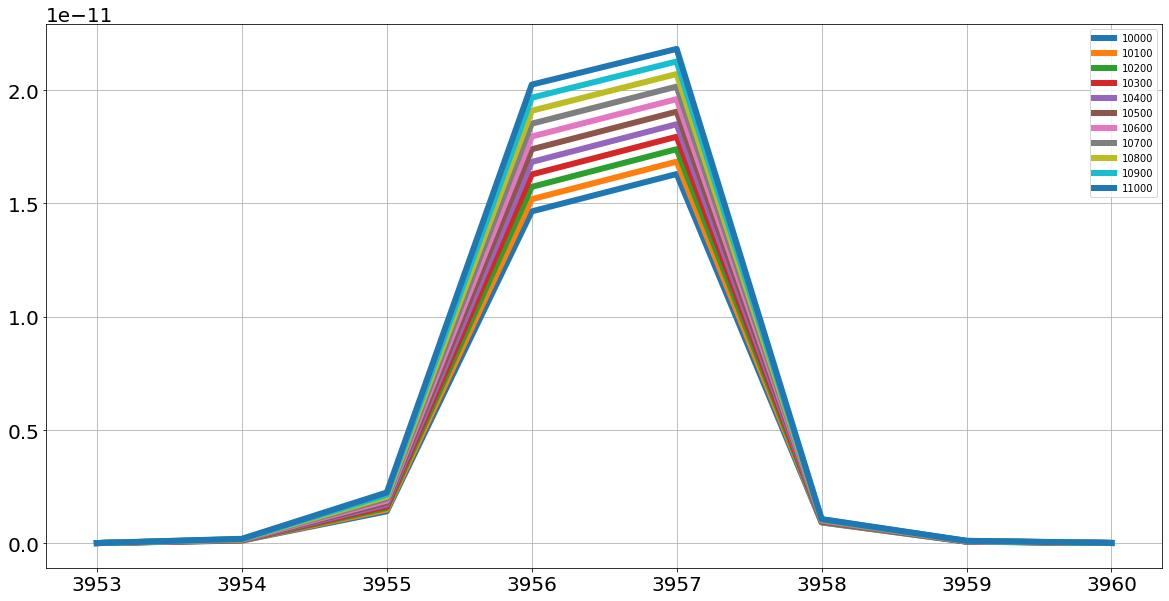

In [31]:
k, l = 0, len(paths_to_radiation);
for ind,elem in enumerate(paths_to_radiation[k:l]):
    #print(paths_to_radiation[ind].split('/')[-1].split('.')[0].split('_')[2])
    rad = get_radiation_data(ind+k,paths_to_radiation,1)
    rad = rad.detach().cpu().numpy()
    #plt.plot(np.arange(rad.shape[-1]), rad[0,:], label=paths_to_radiation[ind+k].split('/')[-1].split('.')[0].split('_')[2])
    plt.plot(np.arange(3953,3961), rad[0,3953:3961], label=paths_to_radiation[ind+k].split('/')[-1].split('.')[0].split('_')[2])
plt.grid(True)
plt.legend()
plt.show()

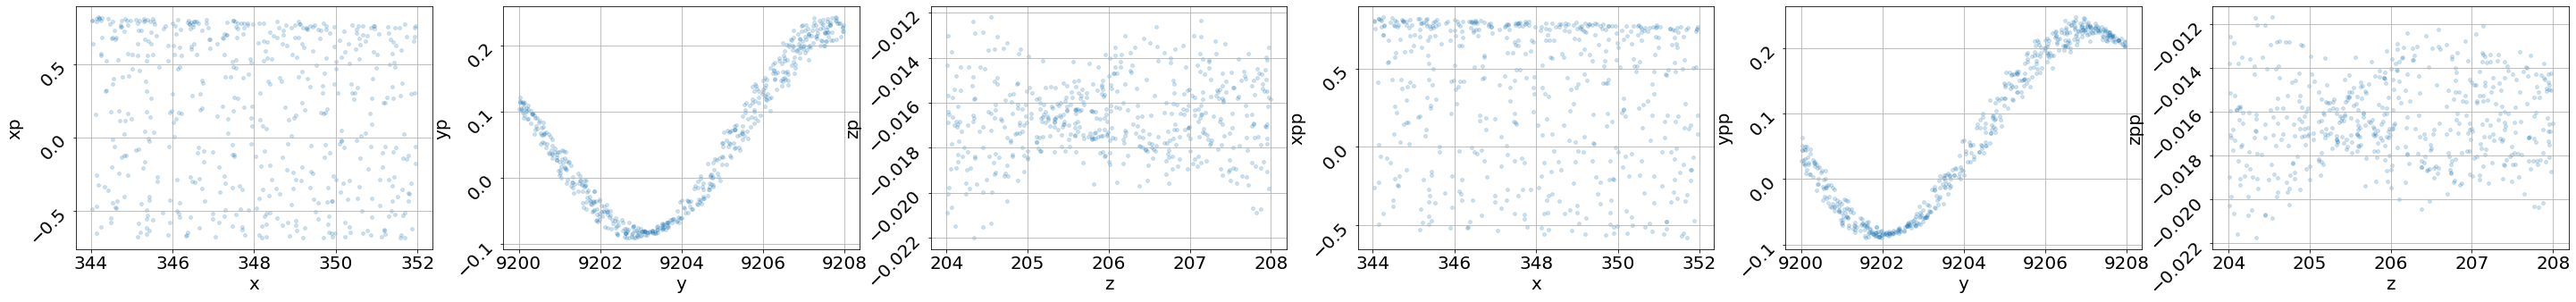

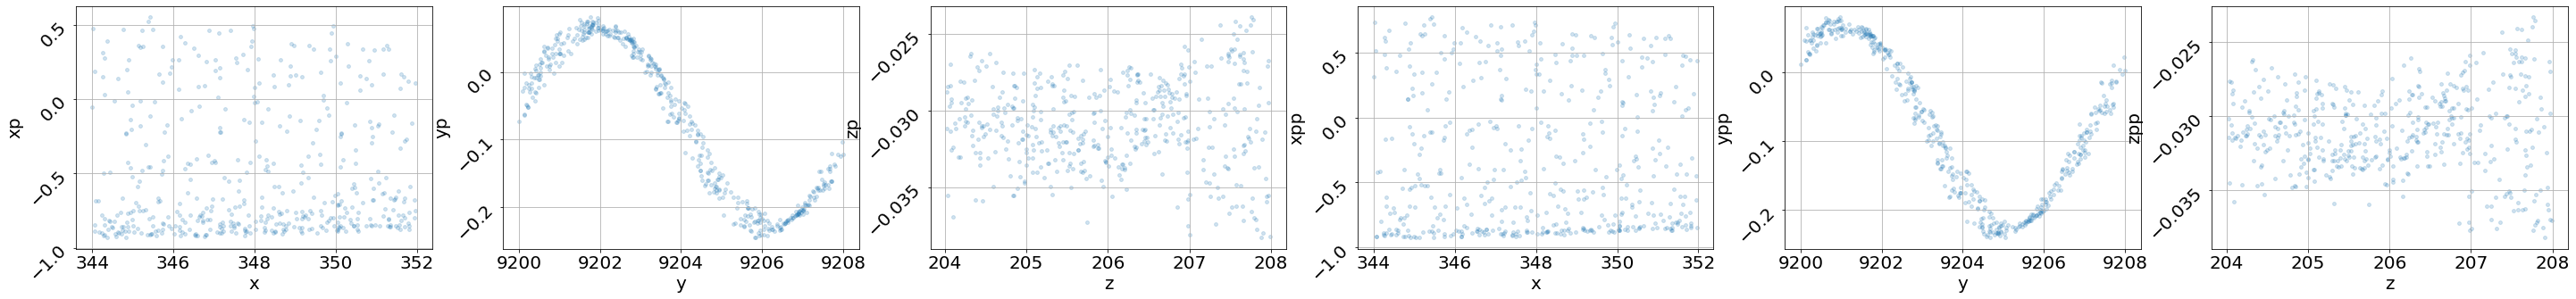

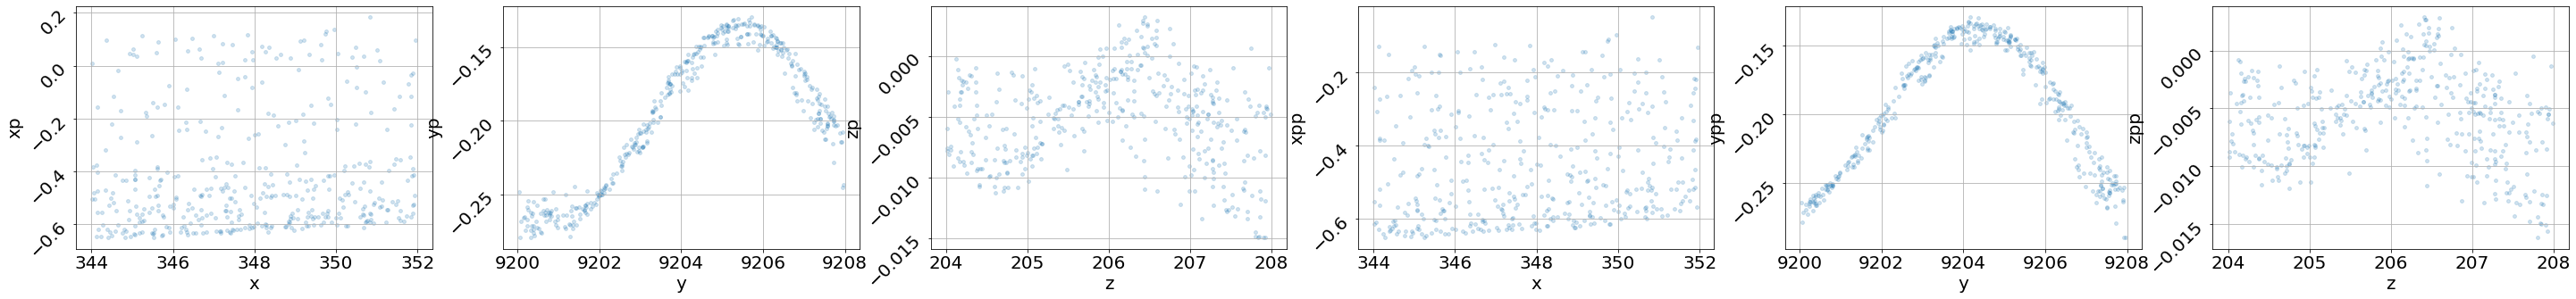

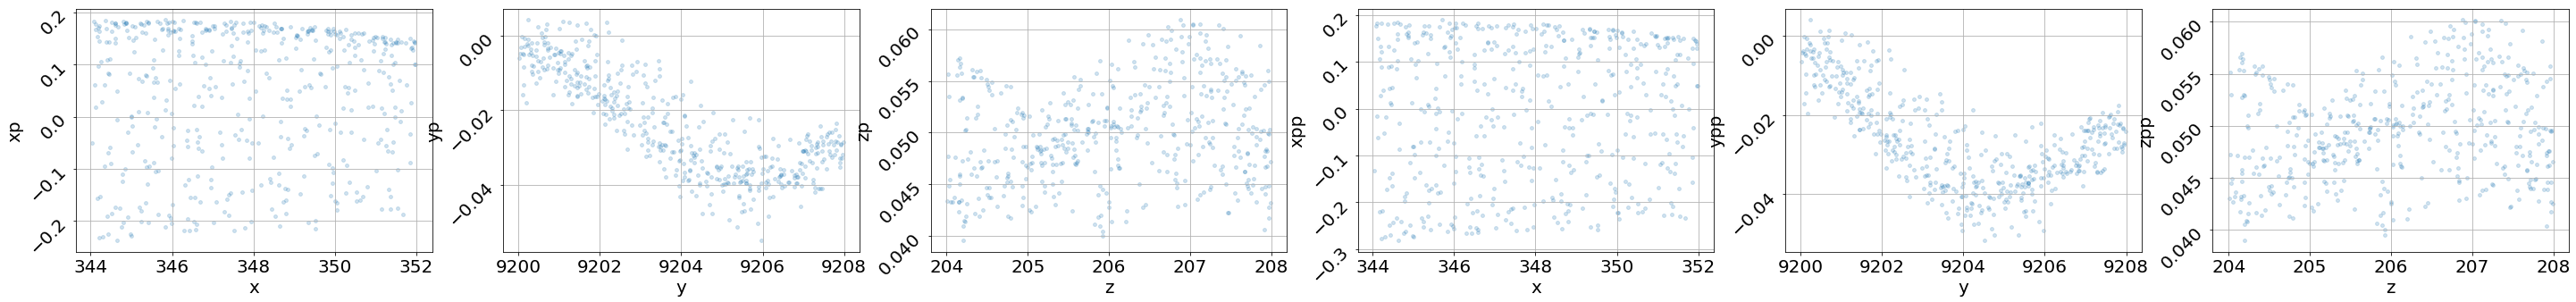

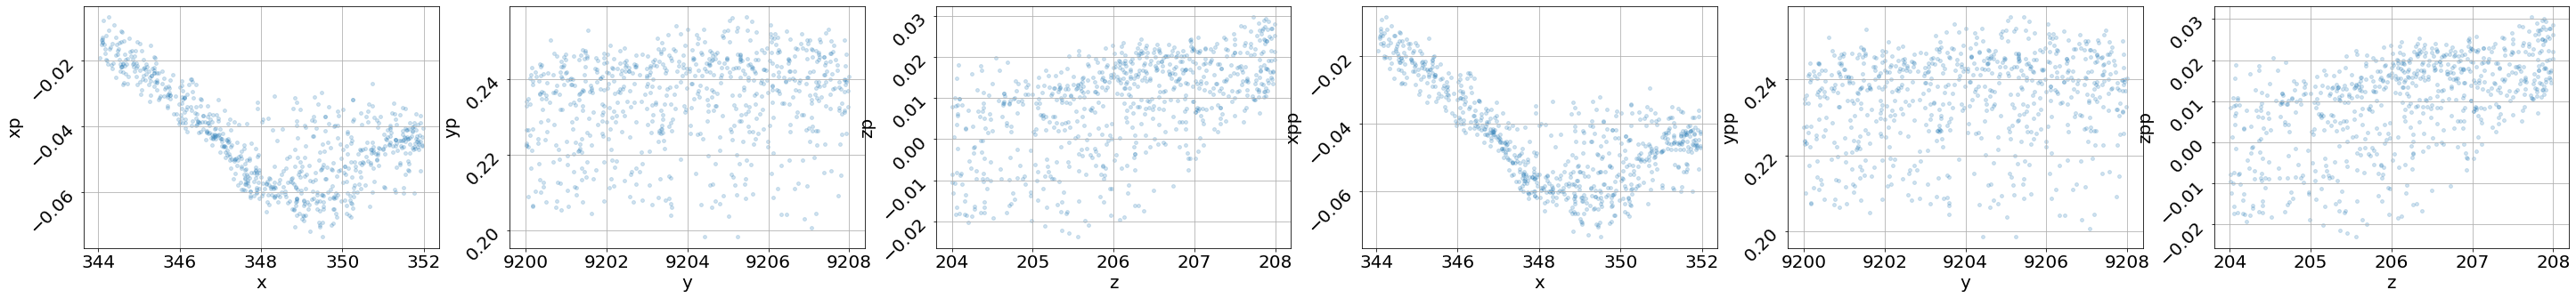

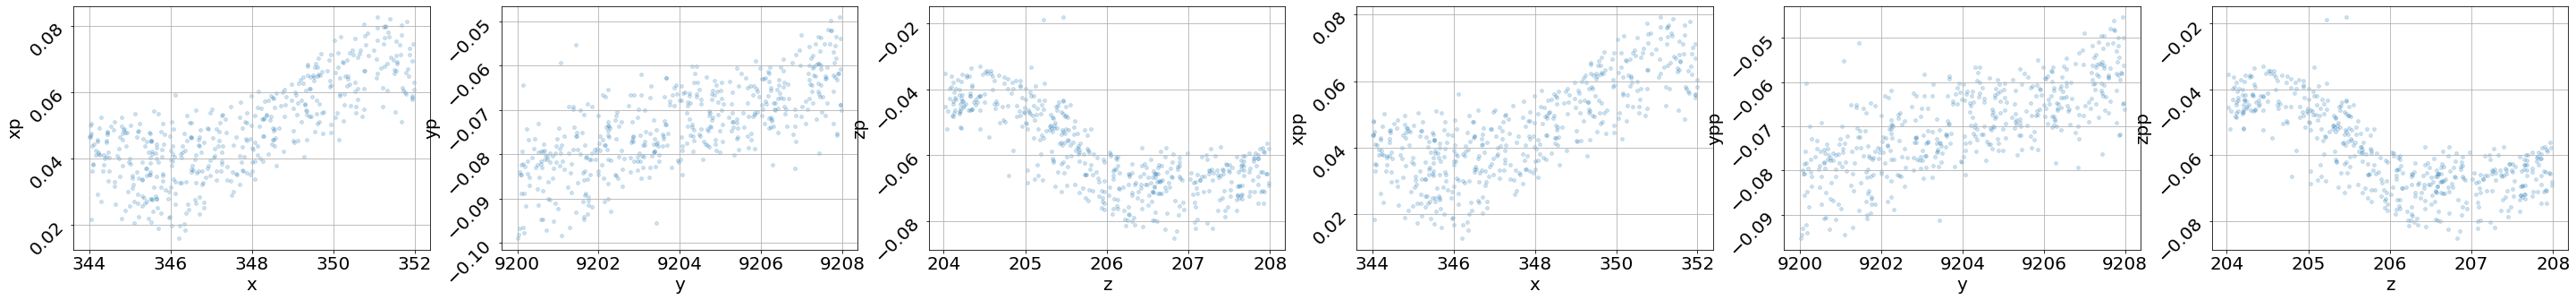

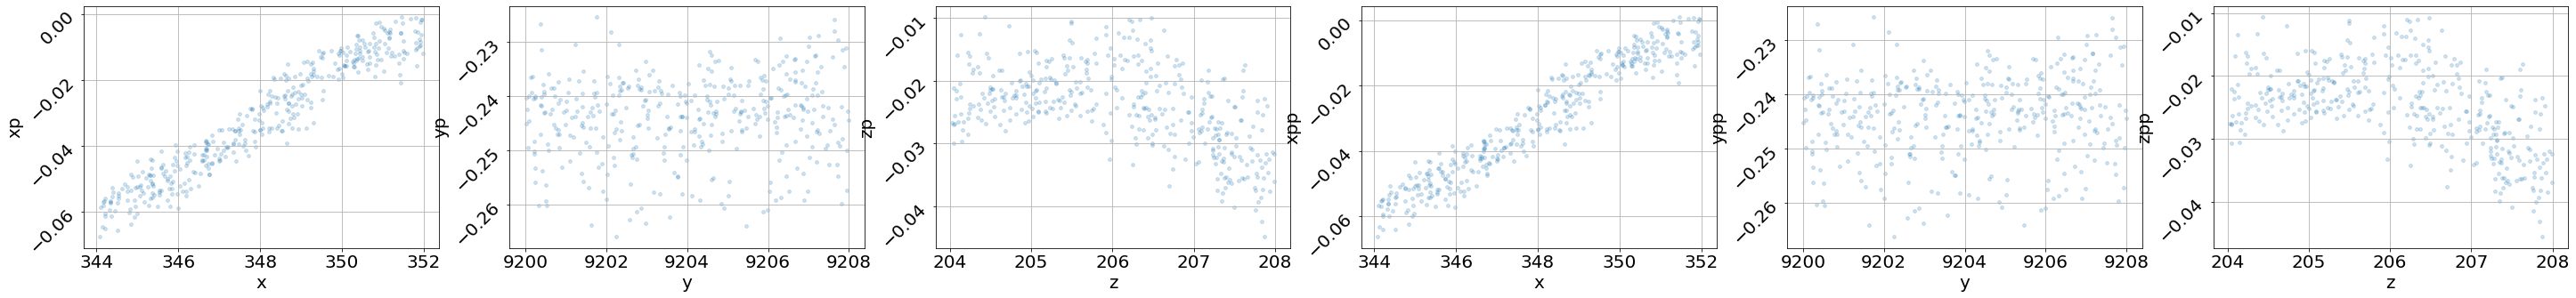

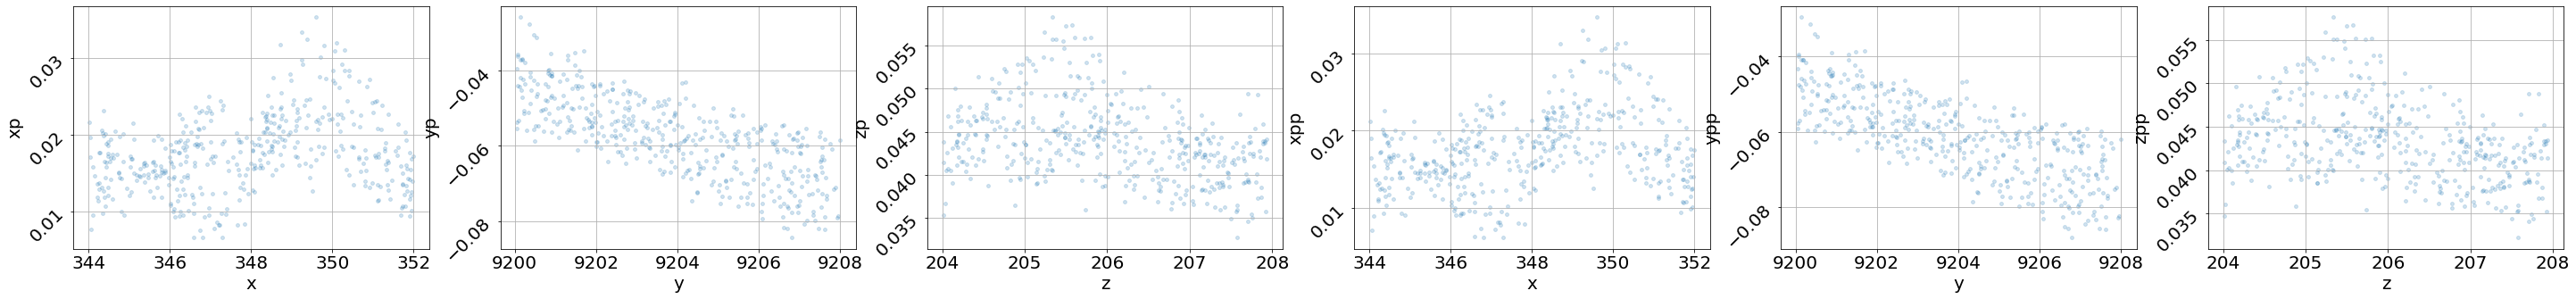

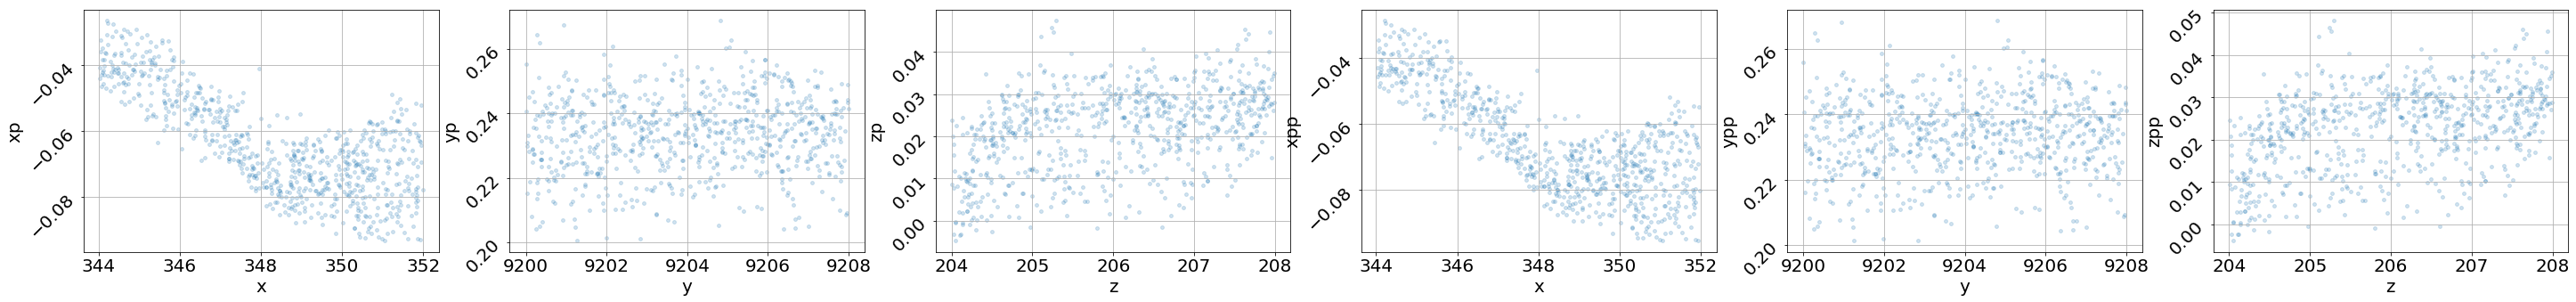

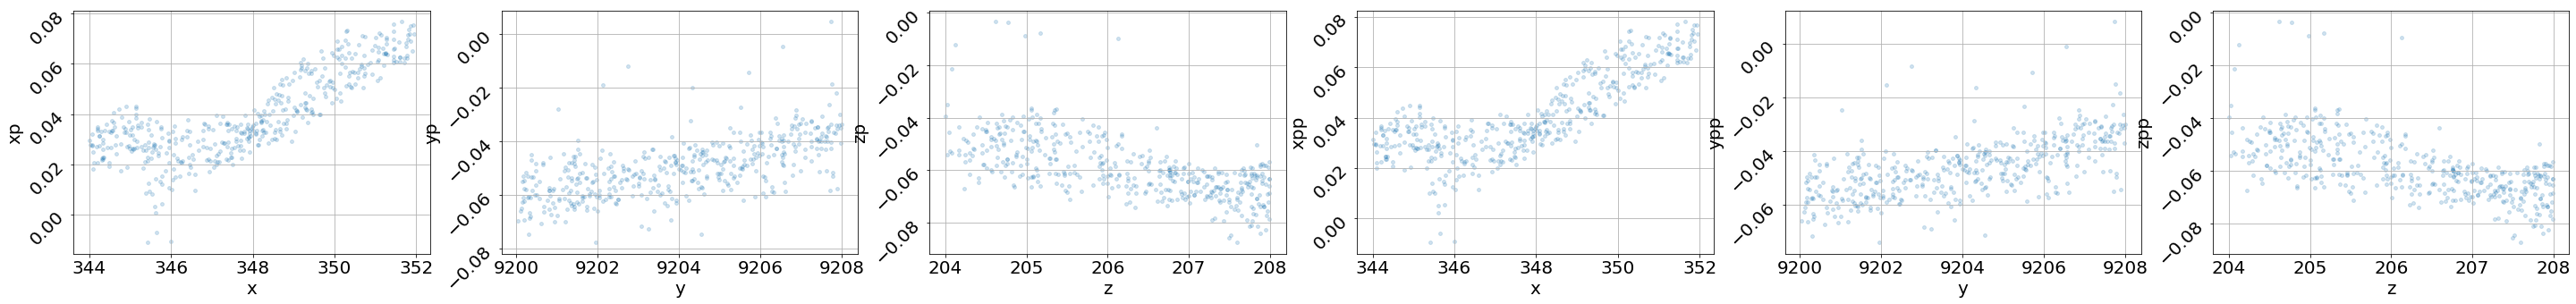

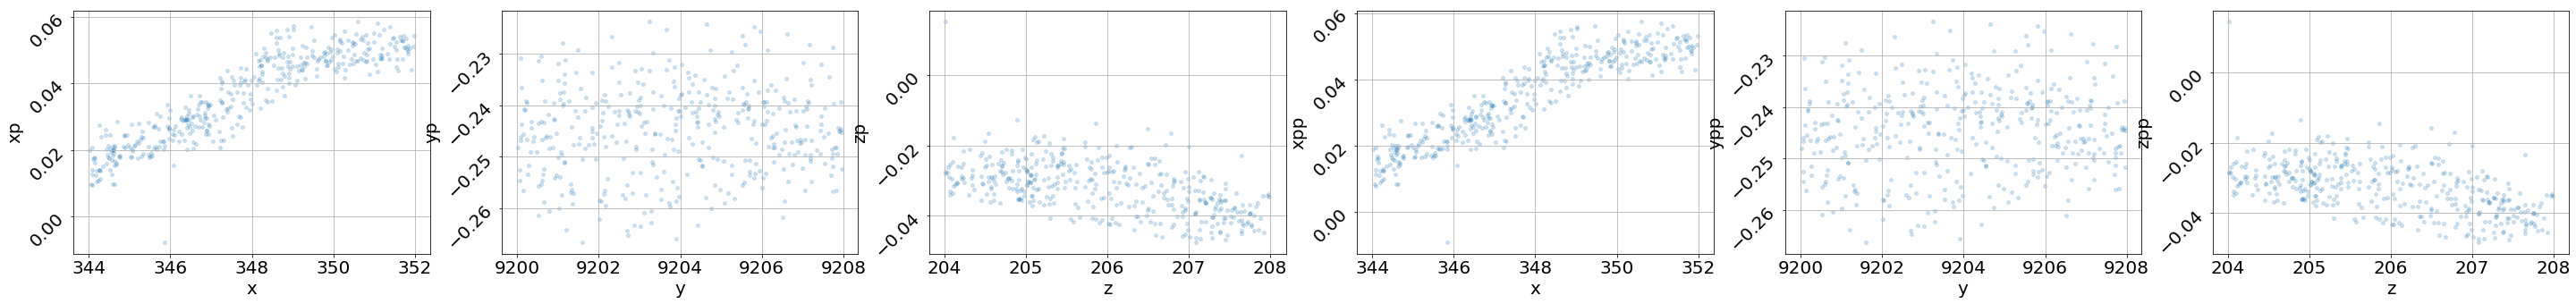

In [16]:
for path in all_timesteps:
    x = np.loadtxt(path)
    figsize1 = 50
    figsize2 = 5
    labels_x = ['x', 'y', 'z', 'x', 'y', 'z']
    labels_y = ['xp', 'yp', 'zp', 'xpp', 'ypp', 'zpp']
    comp_xs = [0,1,2,0,1,2]
    fig, axs = plt.subplots(1, 6, figsize=(figsize1,figsize2))
    for i in range(6):
        plot_2D(x, comp_x=comp_xs[i], comp_y=i+3, axs=axs[i], label_x=labels_x[i], label_y=labels_y[i])

In [17]:
import time

models[0].device = 'cuda'
models[0].to('cuda')
#s = time.time()
models[0].train_(datasets[0],
               datasets[0],
               optimizers[0],
               epochs=1001,
               batch_size=1,
               test_epoch=100,
               test_pointcloud=None, test_radiation=None, log_plots=None,
               path_to_models='/bigdata/hplsim/aipp/Anna/all_timesteps_models/RESModels_'+supercell)
#e = time.time()
#print('time on cuda, MAF training: ', e-s, 's')
#break

Total number of points:  2
Size of loader:  2
epoch : 1/1001,
	loss_avg = 25.466962814331055
epoch : 101/1001,
	loss_avg = -3.902275323867798
epoch : 201/1001,
	loss_avg = -6.420698881149292
epoch : 301/1001,
	loss_avg = -6.569680452346802
epoch : 401/1001,
	loss_avg = -9.985641002655029
epoch : 501/1001,
	loss_avg = -10.329260826110840
epoch : 601/1001,
	loss_avg = -10.154588699340820
epoch : 701/1001,
	loss_avg = -11.295684337615967


KeyboardInterrupt: 

In [11]:
param_size = 0
for param in models[0].model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in models[0].model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 970.353MB


10000_43_1150_51
10100_43_1150_51
10200_43_1150_51
10300_43_1150_51
10400_43_1150_51
10500_43_1150_51
10600_43_1150_51
10700_43_1150_51
10800_43_1150_51
10900_43_1150_51
11000_43_1150_51


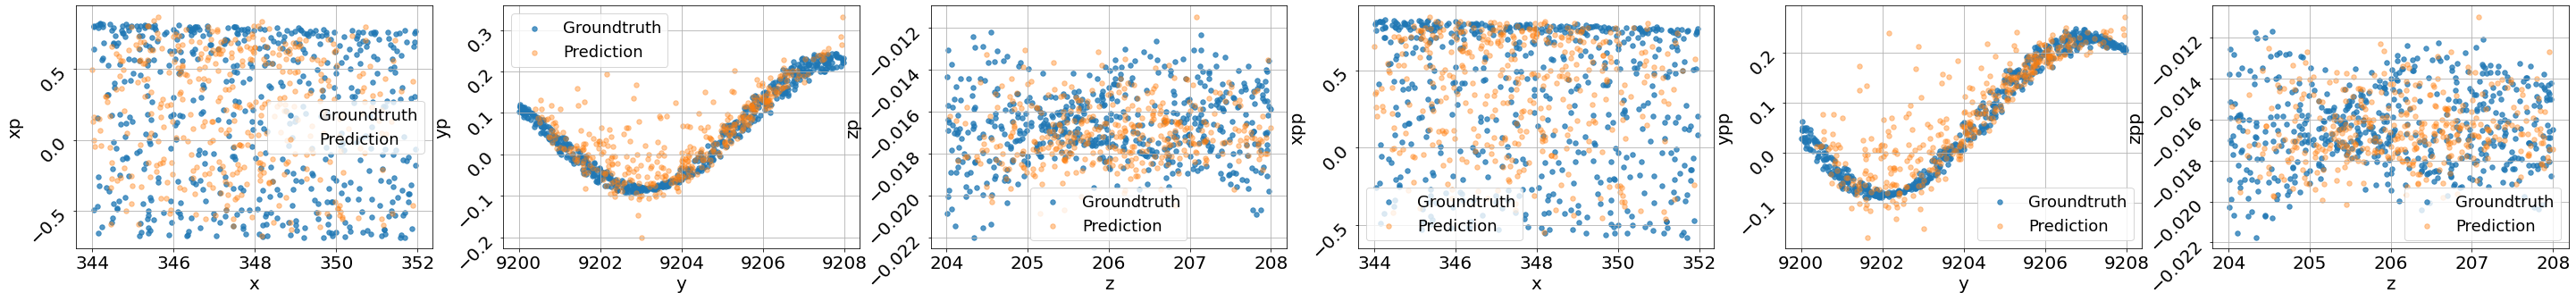

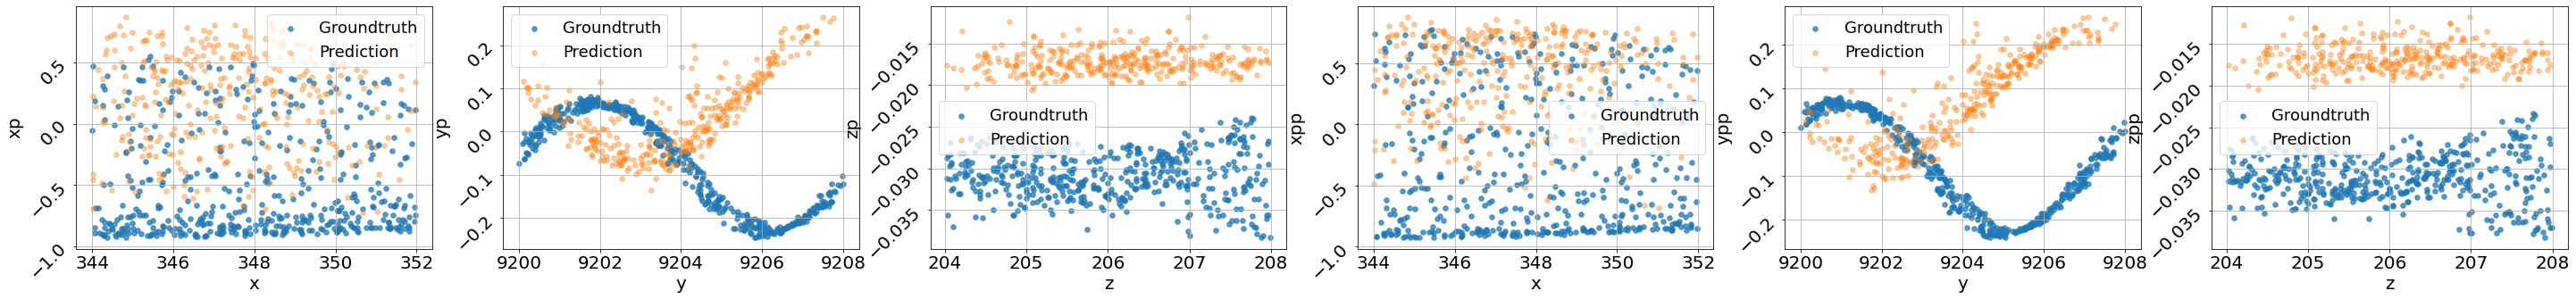

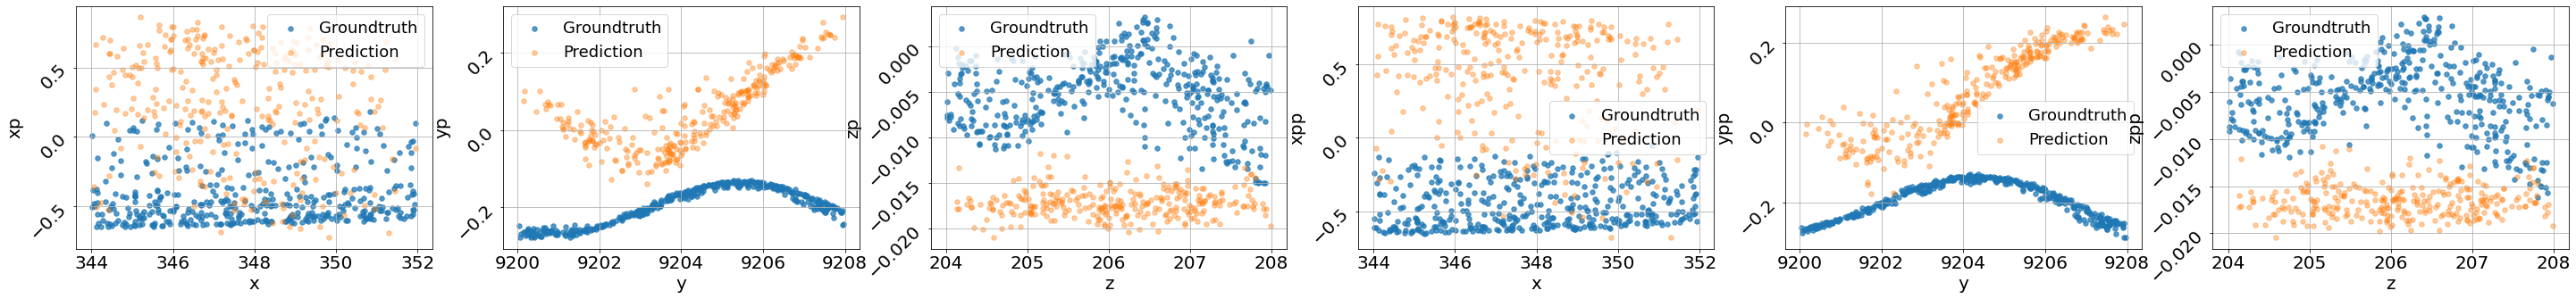

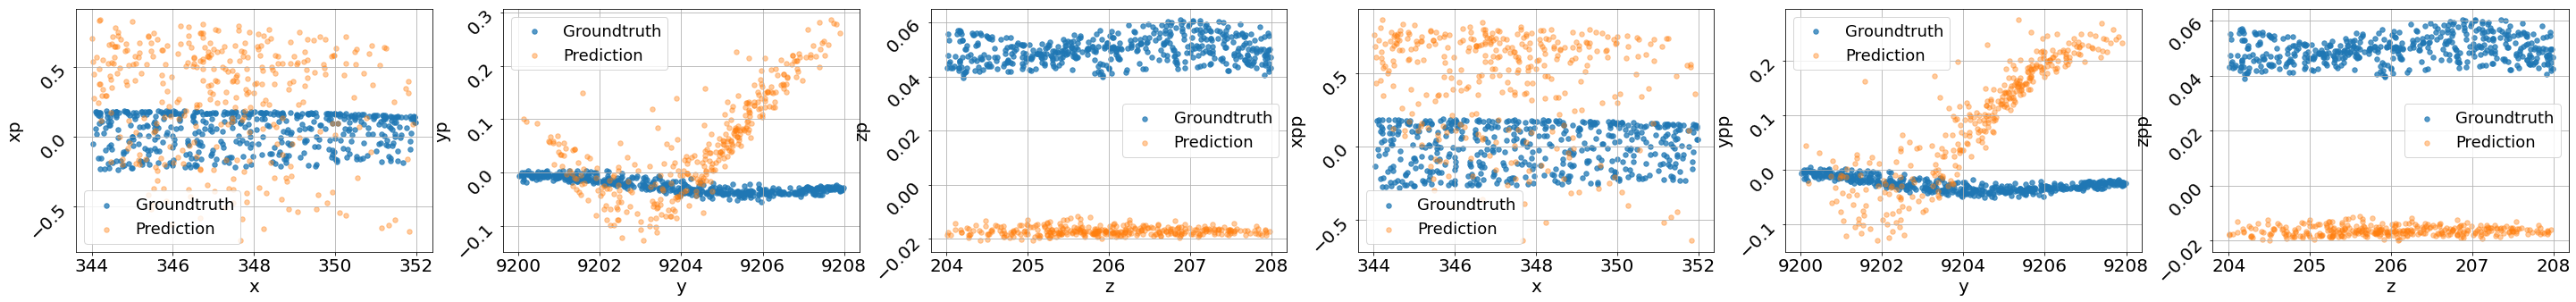

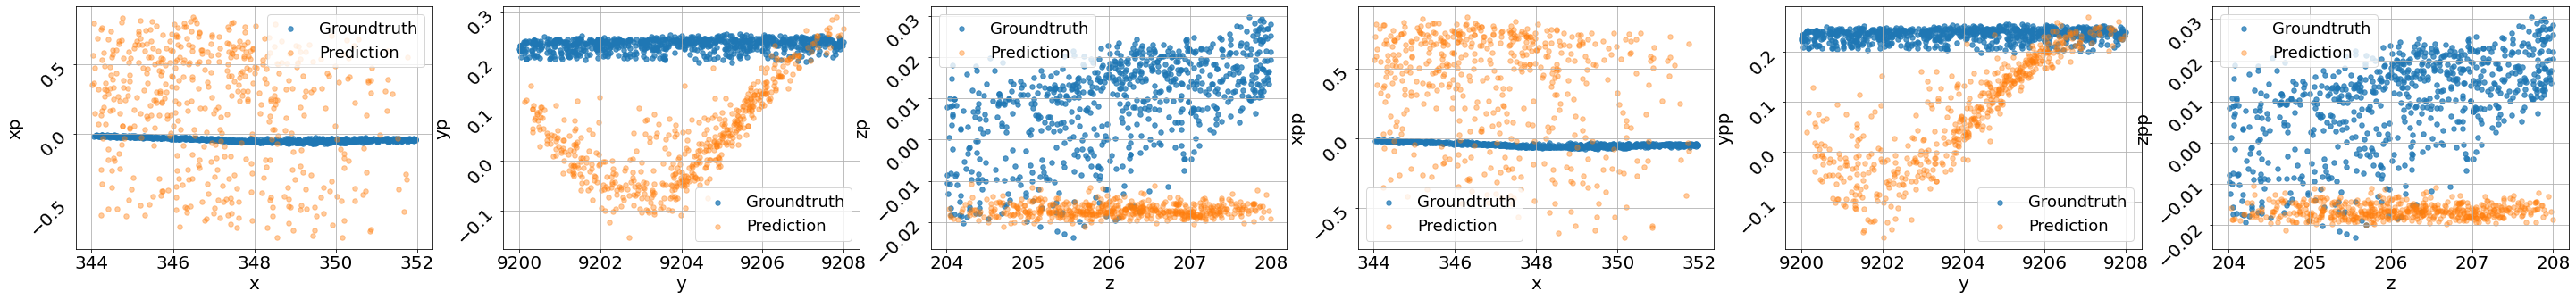

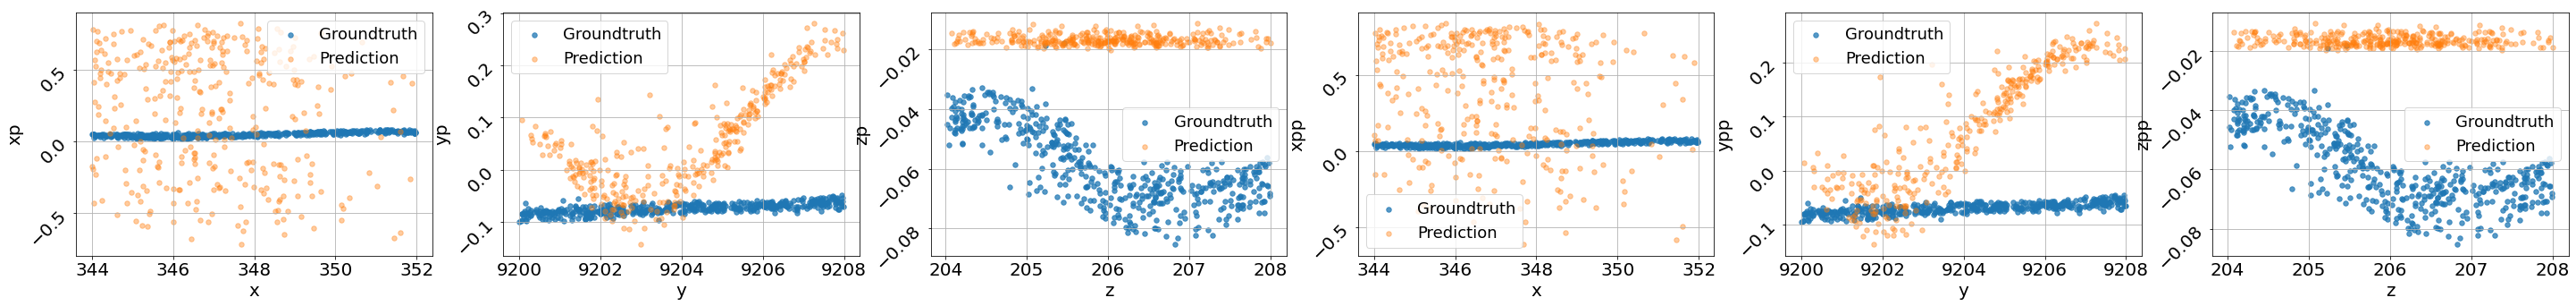

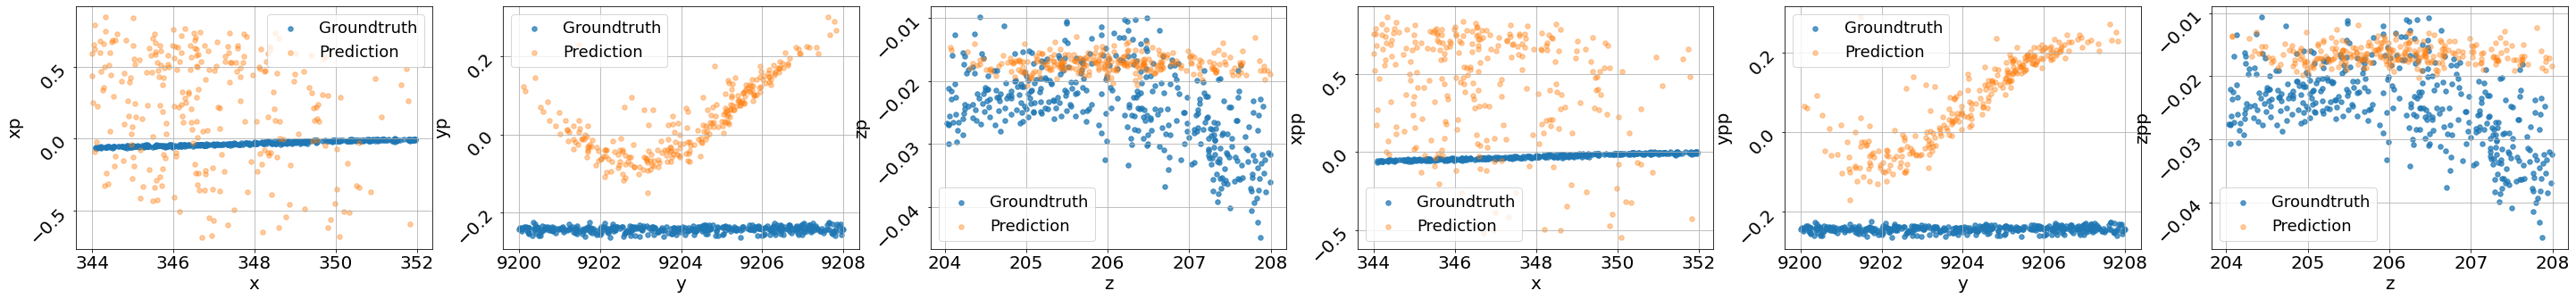

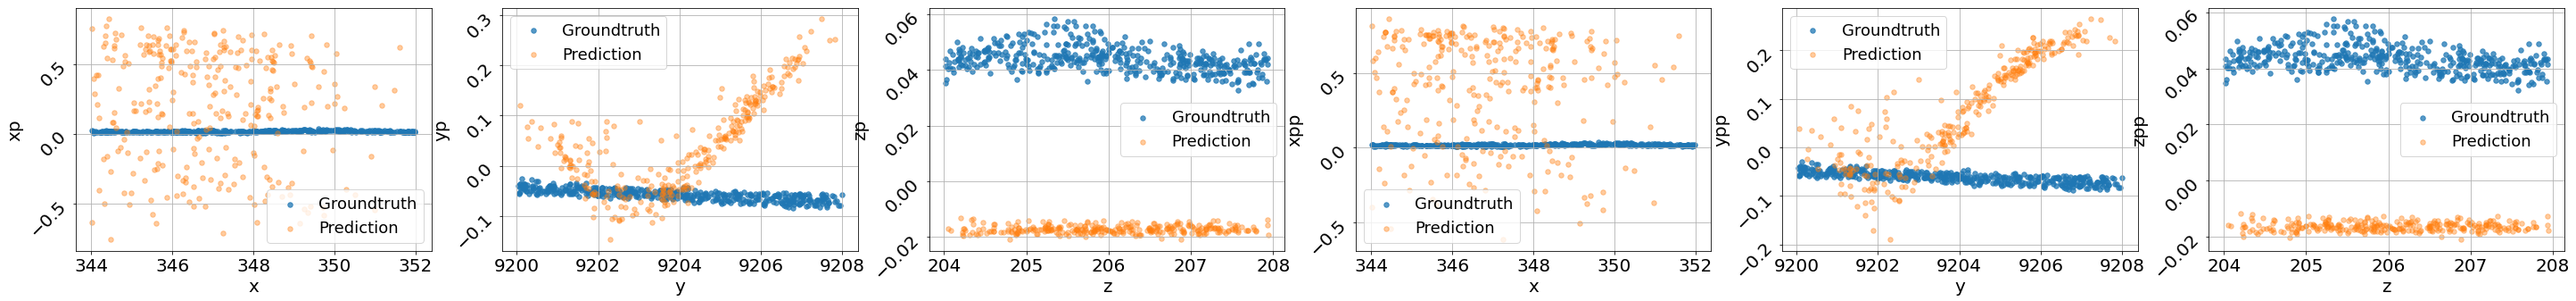

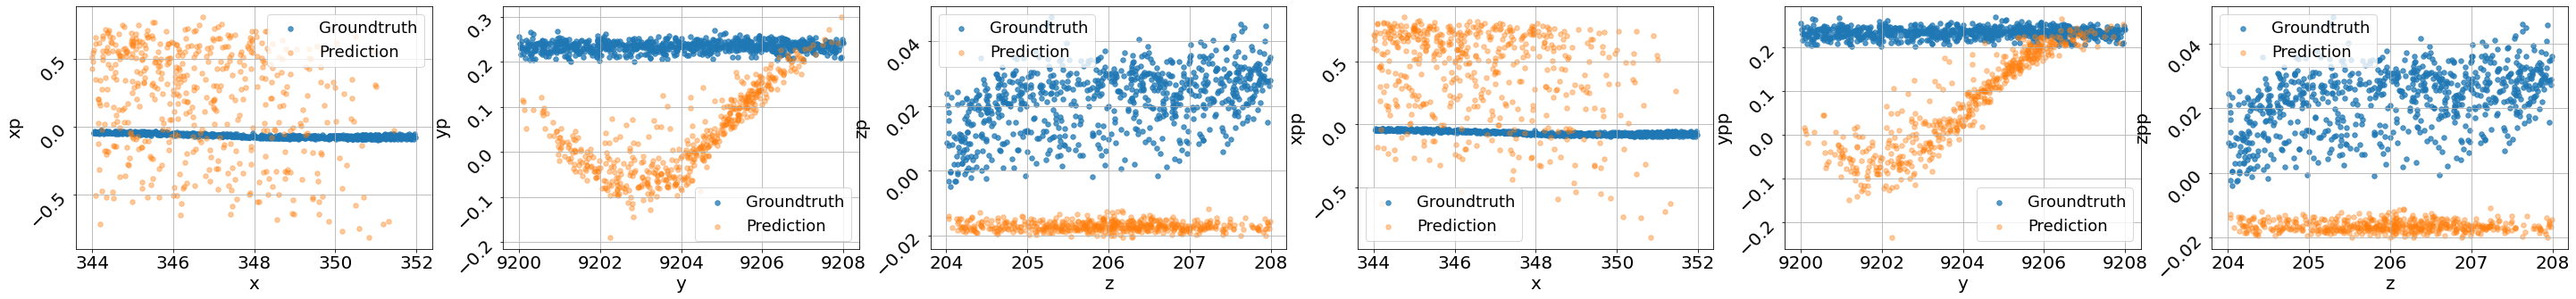

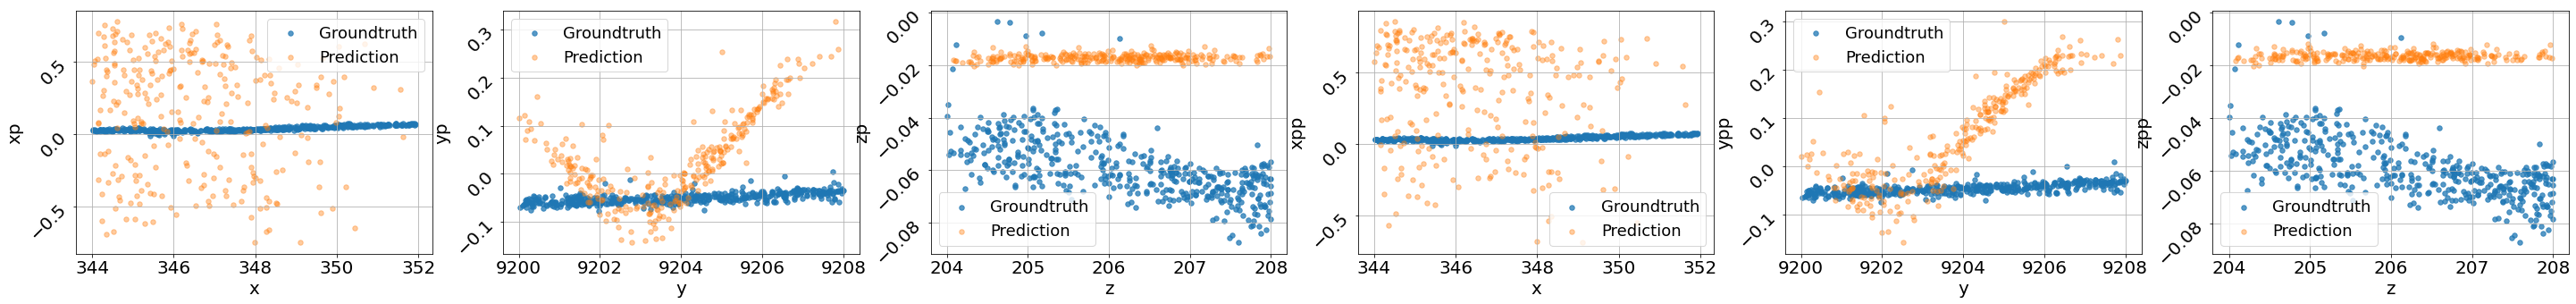

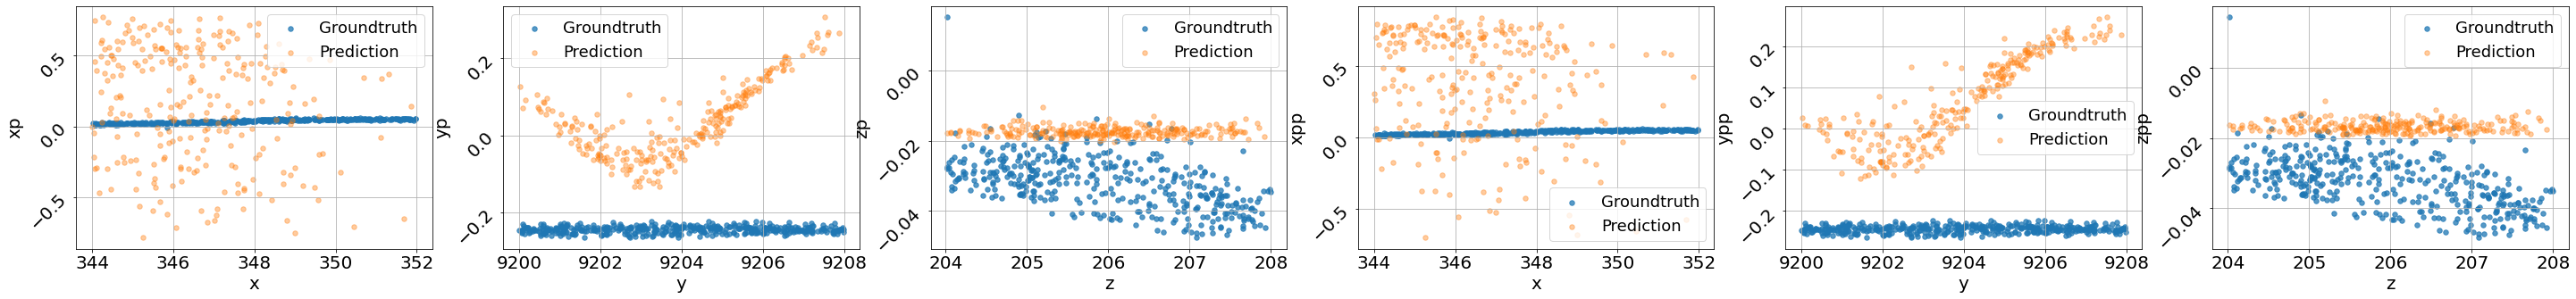

In [12]:
labels_x = ['x', 'y', 'z', 'x', 'y', 'z']
labels_y = ['xp', 'yp', 'zp', 'xpp', 'ypp', 'zpp']

for ind in range(len(all_timesteps)):
    print(all_timesteps[ind].split('/')[-1].split('.')[0])
    #print(paths_to_radiation[ind],'\n')
    x_ps = np.loadtxt(all_timesteps[ind])
    rad = get_radiation_data(ind,paths_to_radiation,x_ps.shape[0])
    vmin_rad, vmax_rad = torch.full((x_ps.shape[0],65536), datasets[0].vmin_rad_), torch.full((x_ps.shape[0], 65536), datasets[0].vmax_rad_)
    rad = data_preprocessing.normalize_point(rad, vmin_rad, vmax_rad, datasets[0].a, datasets[0].b)
    
    x_ps_rec = models[0].sample_pointcloud(rad.to(models[0].device))
    xyz = [int(elem) for elem in supercell.split('_')]

    x_ps_rec = x_ps_rec[(x_ps_rec[:,0] < (xyz[0]+1)*8) & (x_ps_rec[:,0] > xyz[0]*8)
                     & (x_ps_rec[:,1] < (xyz[1]+1)*8) & (x_ps_rec[:,1] > xyz[1]*8)
                     & (x_ps_rec[:,2] < (xyz[2]+1)*4) & (x_ps_rec[:,2] > xyz[2]*4)]
#                      & (x_ps_rec[:,3] > -10) & (x_ps_rec[:,3] < 10)
#                        & (x_ps_rec[:,4] > -10) & (x_ps_rec[:,4] < 10)
#                        & (x_ps_rec[:,5] > -10) & (x_ps_rec[:,5] < 10)
#                        & (x_ps_rec[:,6] > -10) & (x_ps_rec[:,6] < 10)
#                        & (x_ps_rec[:,7] > -10) & (x_ps_rec[:,7] < 10)
#                        & (x_ps_rec[:,8] > -10) & (x_ps_rec[:,8] < 10)]
    #x_ps_rec = reject_outliers(x_ps_rec.detach().cpu().numpy())
    
    figsize1 = 50
    figsize2 = 5
    fig, axs = plt.subplots(1, 6, figsize=(figsize1,figsize2))

    for i in range(6):
        plot_2D_GTandRec(x_ps, x_ps_rec,
                         comp_x=comp_xs[i], comp_y=i+3, axs=axs[i],
                         label_x=labels_x[i], label_y=labels_y[i])

In [ ]:
#supercell = [int(k) for k in test_pointcloud.split('/')[-1].split('.')[0].split('_')[1:]]
iteration = '10700'
pointcloud_tensor = all_cells

num_particles = 33284
idx = np.random.randint(pointcloud_tensor.shape[0], size=num_particles)
pointcloud_tensor = pointcloud_tensor[idx, :]
radiation_tensor = torch.Tensor([0.5,0.5]).float().repeat(pointcloud_tensor.shape[0], 1)

labels_x = ['x', 'y', 'z', 'x', 'y', 'z']
labels_y = ['xp', 'yp', 'zp', 'xpp', 'ypp', 'zpp']

pred_pointclouds = []
for ind in range(len(supercells)):
    radiation_tensor = torch.Tensor([0.5,0.5]).float().repeat(file_sizes[ind], 1)
    pred_pointclouds.append((models[ind].sample_pointcloud(radiation_tensor.to(models[ind].device), radiation_tensor.shape[0])).detach().cpu().numpy())

pred_pointcloud = np.concatenate([arr for arr in pred_pointclouds], axis=0)
print(pred_pointcloud.shape)
#pred_pointcloud = pred_pointcloud_full.detach().cpu().numpy()

In [ ]:
figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 6, figsize=(figsize1,figsize2))

for i in range(6):
    plot_2D_GTandRec(pointcloud_tensor, pred_pointcloud,
                     comp_x=i, comp_y=i+3, axs=axs[i],
                     label_x=labels_x[i], label_y=labels_y[i])
    
figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 6, figsize=(figsize1,figsize2))
for i in range(6):
    plot_2D(pointcloud_tensor, comp_x=i, comp_y=i+3, axs=axs[i], label_x=labels_x[i], label_y=labels_y[i])

figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 6, figsize=(figsize1,figsize2))
for i in range(6):
    plot_2D(pred_pointcloud, comp_x=i, comp_y=i+3, axs=axs[i], label_x=labels_x[i], label_y=labels_y[i])
    
figsize1 = 30
figsize2 = 10
#labels = label_x+labels_y
fig, axs = plt.subplots(3, 3, figsize=(figsize1,figsize2))
for i in range(3):
    plot_hist(pointcloud_tensor, pred_pointcloud, comp_x=i, axs=axs[0,i], label_x=labels_x[i])
for i in range(3):
    plot_hist(pointcloud_tensor, pred_pointcloud, comp_x=i+3, axs=axs[1,i], label_x=labels_y[i])
    
for i in range(3):
    plot_hist(pointcloud_tensor, pred_pointcloud, comp_x=i+6, axs=axs[2,i], label_x=labels_y[i+3])

In [ ]:
def plot_per_slice(pc, slice_along, num_slices, comp_of_interest, axs, label='Number of particles'):
    if comp_of_interest is not None:
        comp_of_interest = comp_of_interest - 1

    slices = [np.min(pc[:, slice_along]) + (np.max(pc[:, slice_along]) - np.min(pc[:, slice_along])) * i/num_slices for i in range(num_slices)]
    pc_ = np.concatenate((pc, np.zeros((pc.shape[0], 1))), axis=1)

    for ind in range(len(slices)-1):
        pc_[:, -1][(pc_[:, slice_along]>=slices[ind]) & (pc_[:, slice_along]<=slices[ind+1])] = ind
    pc_[:, -1][(pc_[:, slice_along]>=slices[-1])] = len(slices) - 1

    if comp_of_interest is not None:
        mean_energy = [np.mean(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if (pc_[:, comp_of_interest][pc_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices))]
        #std_energy = [np.std(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if pc_[:, comp_of_interest][pc_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices)) ]
        axs.plot([slice_ for slice_ in slices], mean_energy)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

    if comp_of_interest == None:
        num_particles = [pc_[pc_[:,-1]==ind].shape[0] for ind in range(len(slices))]
        axs.plot([slice_ for slice_ in slices], num_particles)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

def plot_per_slice_GTandRec(pc, pc_pred, slice_along, num_slices, comp_of_interest, axs, label='Number of particles'):
    if pc_pred is not None:
        slices_pred = [np.min(pc_pred[:, slice_along]) + (np.max(pc_pred[:, slice_along]) - np.min(pc_pred[:, slice_along])) * i/num_slices for i in range(num_slices)]
        pc_pred_ = np.concatenate((pc_pred, np.zeros((pc_pred.shape[0], 1))), axis=1)

        for ind in range(len(slices_pred)-1):
            pc_pred_[:, -1][(pc_pred_[:, -3]>=slices_pred[ind]) & (pc_pred_[:, -3]<=slices_pred[ind+1])] = ind
        pc_pred_[:, -1][(pc_pred_[:, -3]>=slices_pred[-1])] = len(slices_pred) - 1
    
    if comp_of_interest is not None:
        comp_of_interest = comp_of_interest - 1

    slices = [np.min(pc[:, slice_along]) + (np.max(pc[:, slice_along]) - np.min(pc[:, slice_along])) * i/num_slices for i in range(num_slices)]
    pc_ = np.concatenate((pc, np.zeros((pc.shape[0], 1))), axis=1)

    for ind in range(len(slices)-1):
        pc_[:, -1][(pc_[:, slice_along]>=slices[ind]) & (pc_[:, slice_along]<=slices[ind+1])] = ind
    pc_[:, -1][(pc_[:, slice_along]>=slices[-1])] = len(slices) - 1

    if comp_of_interest is not None:
        mean_energy = [np.mean(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if (pc_[:, comp_of_interest][pc_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices))]
        std_energy = [np.std(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if pc_[:, comp_of_interest][pc_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices)) ]

        #axs.plot([slice_ for slice_ in slices], mean_energy, label="Groundtruth")
        if pc_pred is not None:
            print('plot pred', slices_pred)
            mean_energy_pred = [np.mean(pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]) if (pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices_pred))]
            std_energy_pred = [np.std(pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]) if pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices_pred)) ]
            axs.plot([slice_ for slice_ in slices_pred], mean_energy_pred, label="Reconstruction")
            
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        axs.legend(prop={'size': 20})


    if comp_of_interest == None:
        num_particles = [pc_[pc_[:,-1]==ind].shape[0] for ind in range(len(slices))]
        axs.plot([slice_ for slice_ in slices], num_particles)
        if pc_pred is not None:
            num_particles_pred = [pc_pred_[pc_pred_[:,-1]==ind].shape[0] for ind in range(len(slices_pred))]
            axs.plot([slice_ for slice_ in slices_pred], num_particles_pred)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

In [ ]:
slice_along = 2 #z: 2
num_slices = 100
comp_of_interest = -3
figsize1 = 35
figsize2 = 5

fig, axs = plt.subplots(1, 2, figsize=(figsize1,figsize2))
plot_per_slice_GTandRec(pointcloud_tensor, pred_pointcloud,
                        slice_along, num_slices, comp_of_interest,
                        axs[0], label='Number of particles')

plot_per_slice(pred_pointcloud, slice_along, num_slices, comp_of_interest, axs[1], label='Number of particles')

#for i in range(1,4,1):
#    visualizations.plot_per_slice_GTandRec(pointcloud_tensor, pred_pointcloud,
#                        slice_along, num_slices, comp_of_interest=-1*i,
#                        axs=axs[i], label='Mean ' + labels_y[-1*i])